In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.weightstats import ztest

import math
import pandas as pd

In [3]:
clusters = np.load("model_weights/assignments_msl_30_bs512_wind4.npy")
timseries = np.load("data/timeseries.npy")

assigments = pd.DataFrame(clusters, columns=["cluster"],index=timseries)
assigments['year_month'] = assigments.index.to_period("M")

# el nino data
url = "https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt"

elnino = pd.read_csv(url, sep="\s+")
elnino['datetime'] = pd.to_datetime(elnino['YR'].astype(int).astype(str) +\
                                     elnino['MON'].astype(int).astype(str), format='%Y%m')

elnino = elnino.set_index("datetime")[['ANOM']]
elnino.index=pd.to_datetime(elnino.index).to_period("M")

# anom = 0.5
anom = 1
elnino.loc[elnino['ANOM']>anom,'indicator'] = 1 #el nino
elnino.loc[elnino['ANOM']<-anom,'indicator'] = 2 #la nina
elnino['indicator'] = elnino['indicator'].fillna(0) #nothing

#join all 
elnino = assigments.join(elnino,on="year_month")

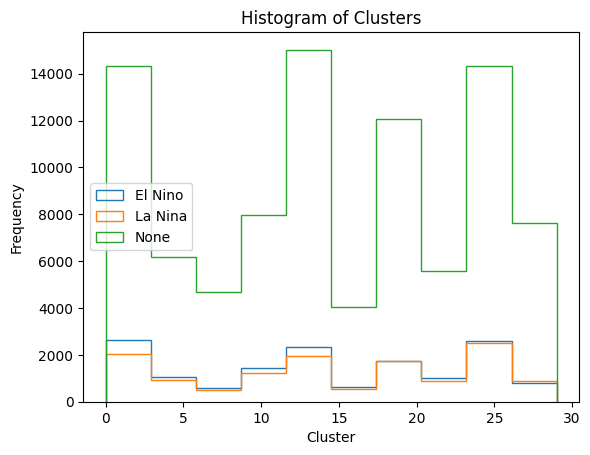

In [4]:
bins = 10
# plt.hist(clusters,label="All", histtype='step', bins=bins)
plt.hist( elnino[elnino['indicator']==1]['cluster'],label="El Nino", histtype='step')
plt.hist( elnino[elnino['indicator']==2]['cluster'],label="La Nina", histtype='step',bins=bins)
plt.hist( elnino[elnino['indicator']==0]['cluster'],label="None", histtype='step',bins=bins)

plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Histogram of Clusters')
plt.legend()
plt.show()

In [5]:
daily_data  = elnino.resample('D')[['cluster']].agg(lambda x: x.mode()[0])
daily_data = daily_data.join(elnino['indicator'])

In [6]:
daily_data['MONTH'] = daily_data.index.month
daily_data_count = daily_data.groupby(['MONTH','indicator'])['cluster'].value_counts().unstack().fillna(0)
daily_data_count

cluster            0      1      2     3     4     5     6     7     8     9   \
MONTH indicator                                                                 
1     0.0         2.0  129.0  144.0  57.0  11.0  12.0   0.0  11.0   1.0  36.0   
      1.0         1.0   19.0   34.0  11.0   0.0   0.0   0.0   3.0   0.0   5.0   
      2.0         0.0   19.0   30.0   4.0   3.0   8.0   0.0   4.0   0.0  14.0   
2     0.0         9.0   79.0  150.0  50.0  19.0   8.0   6.0  15.0   0.0  27.0   
      1.0         2.0   15.0   30.0  14.0   1.0   1.0   2.0   4.0   0.0  10.0   
      2.0         0.0    8.0   38.0   7.0   3.0   2.0   0.0   4.0   0.0   8.0   
3     0.0        13.0   71.0  123.0  43.0  41.0   5.0   7.0  38.0   1.0  53.0   
      1.0         7.0   14.0   18.0   2.0   9.0   0.0   3.0   6.0   0.0   5.0   
      2.0         0.0    3.0    9.0   0.0   1.0   0.0   0.0   1.0   0.0   1.0   
4     0.0        14.0   61.0  122.0  46.0  53.0   8.0  21.0  39.0   1.0  36.0   
      1.0         0.0    6.0    9.0   1.0   2.0   0.0   2.0   1.0   0.0   1.0   
      2.0         1.0    4.0    3.0   0.0   0.0   0.0   5.0   0.0   0.0   1.0   
5     0.0        18.0   46.0  117.0  34.0  58.0   6.0  49.0  26.0   2.0  24.0   
      1.0         1.0    1.0    7.0   0.0   0.0   0.0   5.0   0.0   0.0   3.0   
      2.0         4.0    1.0    7.0   0.0   0.0   0.0   7.0   2.0   0.0   0.0   
6     0.0        21.0   37.0  147.0  15.0  32.0   1.0  84.0   8.0   2.0   8.0   
      1.0         3.0    5.0   19.0   2.0   0.0   1.0   8.0   0.0   1.0   0.0   
      2.0         0.0    3.0   12.0   1.0   4.0   1.0   1.0   1.0   0.0   3.0   
7     0.0        34.0   39.0  126.0  13.0   8.0   6.0  93.0   2.0  12.0   7.0   
      1.0         3.0    7.0   20.0   5.0   0.0   0.0   9.0   0.0   2.0   2.0   
      2.0         2.0    4.0    8.0   1.0   0.0   0.0   8.0   0.0   0.0   1.0   
8     0.0        30.0   31.0  147.0  27.0   6.0   3.0  74.0   2.0  12.0  18.0   
      1.0         3.0    6.0   15.0   2.0   1.0   0.0  12.0   0.0   3.0   2.0   
      2.0         1.0    3.0   15.0   2.0   0.0   0.0   7.0   0.0   1.0   1.0   
9     0.0        26.0   39.0   94.0  44.0  14.0   1.0  59.0   1.0   7.0  50.0   
      1.0         3.0    7.0   10.0   1.0   1.0   2.0   5.0   0.0   1.0   5.0   
      2.0         4.0    6.0   11.0   6.0   1.0   1.0   7.0   0.0   0.0  10.0   
10    0.0        21.0   78.0   98.0  33.0  24.0   9.0  16.0  10.0   2.0  34.0   
      1.0         7.0   17.0    7.0   7.0   0.0   0.0   6.0   0.0   0.0   8.0   
      2.0         6.0   18.0   16.0   6.0   5.0   4.0   5.0   2.0   0.0   7.0   
11    0.0        16.0   43.0   79.0  31.0  16.0   1.0   5.0   7.0   1.0  37.0   
      1.0         7.0   36.0   34.0  13.0   4.0   2.0   5.0   1.0   0.0   8.0   
      2.0         5.0   15.0   40.0   7.0   7.0   2.0   7.0   6.0   1.0  14.0   
12    0.0        12.0   60.0   99.0  38.0   7.0   5.0   2.0   7.0   0.0  36.0   
      1.0         3.0   29.0   45.0  16.0  12.0   6.0   0.0   0.0   0.0  18.0   
      2.0         0.0   31.0   35.0   8.0  10.0   4.0   1.0   2.0   0.0  12.0   

cluster          ...   20    21    22    23    24     25     26    27    28  \
MONTH indicator  ...                                                          
1     0.0        ...  1.0  28.0  13.0   7.0  30.0  106.0   13.0   5.0   0.0   
      1.0        ...  0.0  14.0   0.0   4.0  10.0   32.0    2.0   2.0   0.0   
      2.0        ...  0.0  11.0   5.0   1.0  11.0   23.0    7.0   0.0   0.0   
2     0.0        ...  4.0  26.0  21.0   2.0  30.0   94.0   11.0   7.0   3.0   
      1.0        ...  0.0   0.0  10.0   0.0   3.0    7.0    3.0   2.0   0.0   
      2.0        ...  0.0   3.0   2.0   2.0   2.0   14.0    2.0   1.0   0.0   
3     0.0        ...  7.0  45.0  36.0   6.0  25.0  116.0   13.0   7.0   0.0   
      1.0        ...  4.0   4.0   5.0   0.0   3.0   19.0    3.0   0.0   0.0   
      2.0        ...  0.0   5.0   3.0   0.0   4.0   10.0    0.0   0.0   0.0   
4     0.0        ...  5.0  20.0  53.0   0.0   4.0  1

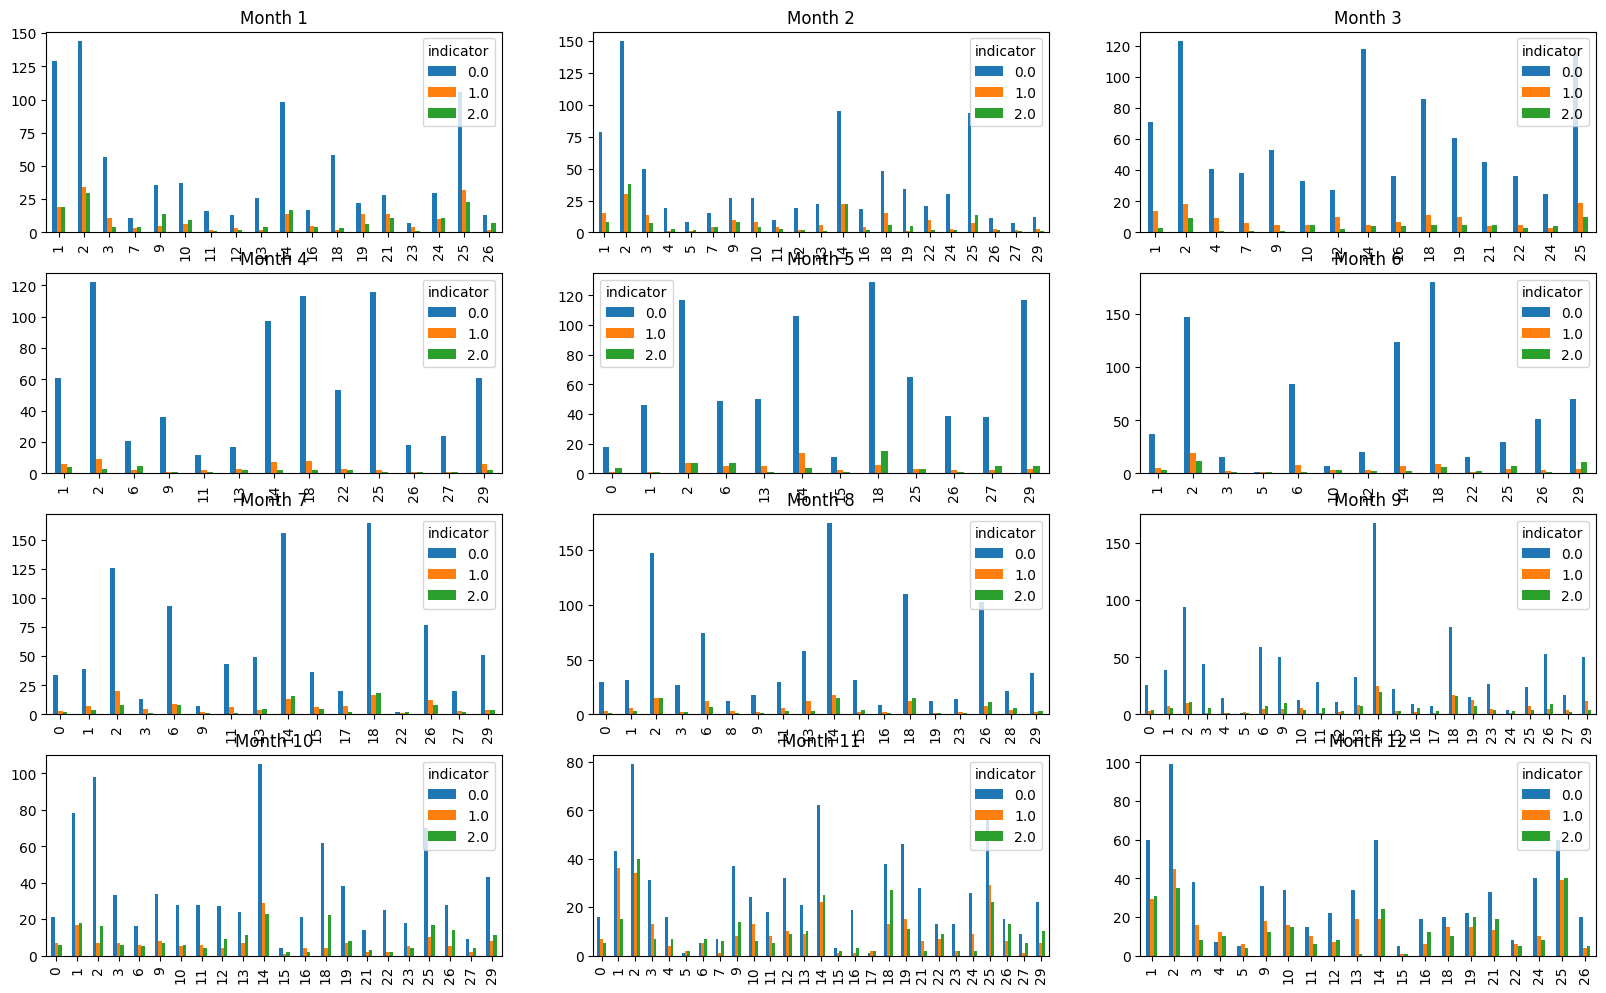

In [7]:
fig, ax = plt.subplots(4,3,figsize=(20,12))

for i in range(1,13):
    daily_data_count.loc[i].T.replace(0,np.nan).dropna()\
        .plot(kind='bar',
              ax=ax[(i-1)//3,(i-1)%3],
              stacked=False,
              title=f'Month {i}')
    
    ax[(i-1)//3,(i-1)%3].set_xlabel('')

plt.show()

# daily_data_count.loc[1].T.replace(0,np.nan).dropna().plot(kind='bar',stacked=False)

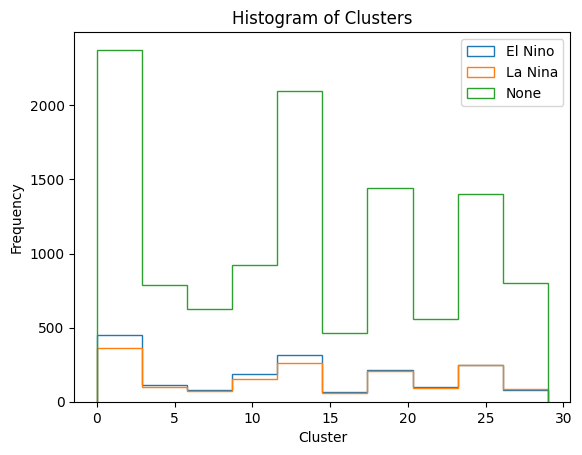

In [8]:
bins = 10
# plt.hist(clusters,label="All", histtype='step', bins=bins)
plt.hist( daily_data[daily_data['indicator']==1]['cluster'],label="El Nino", histtype='step')
plt.hist( daily_data[daily_data['indicator']==2]['cluster'],label="La Nina", histtype='step',bins=bins)
plt.hist( daily_data[daily_data['indicator']==0]['cluster'],label="None", histtype='step',bins=bins)

plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Histogram of Clusters')
plt.legend()
plt.show()

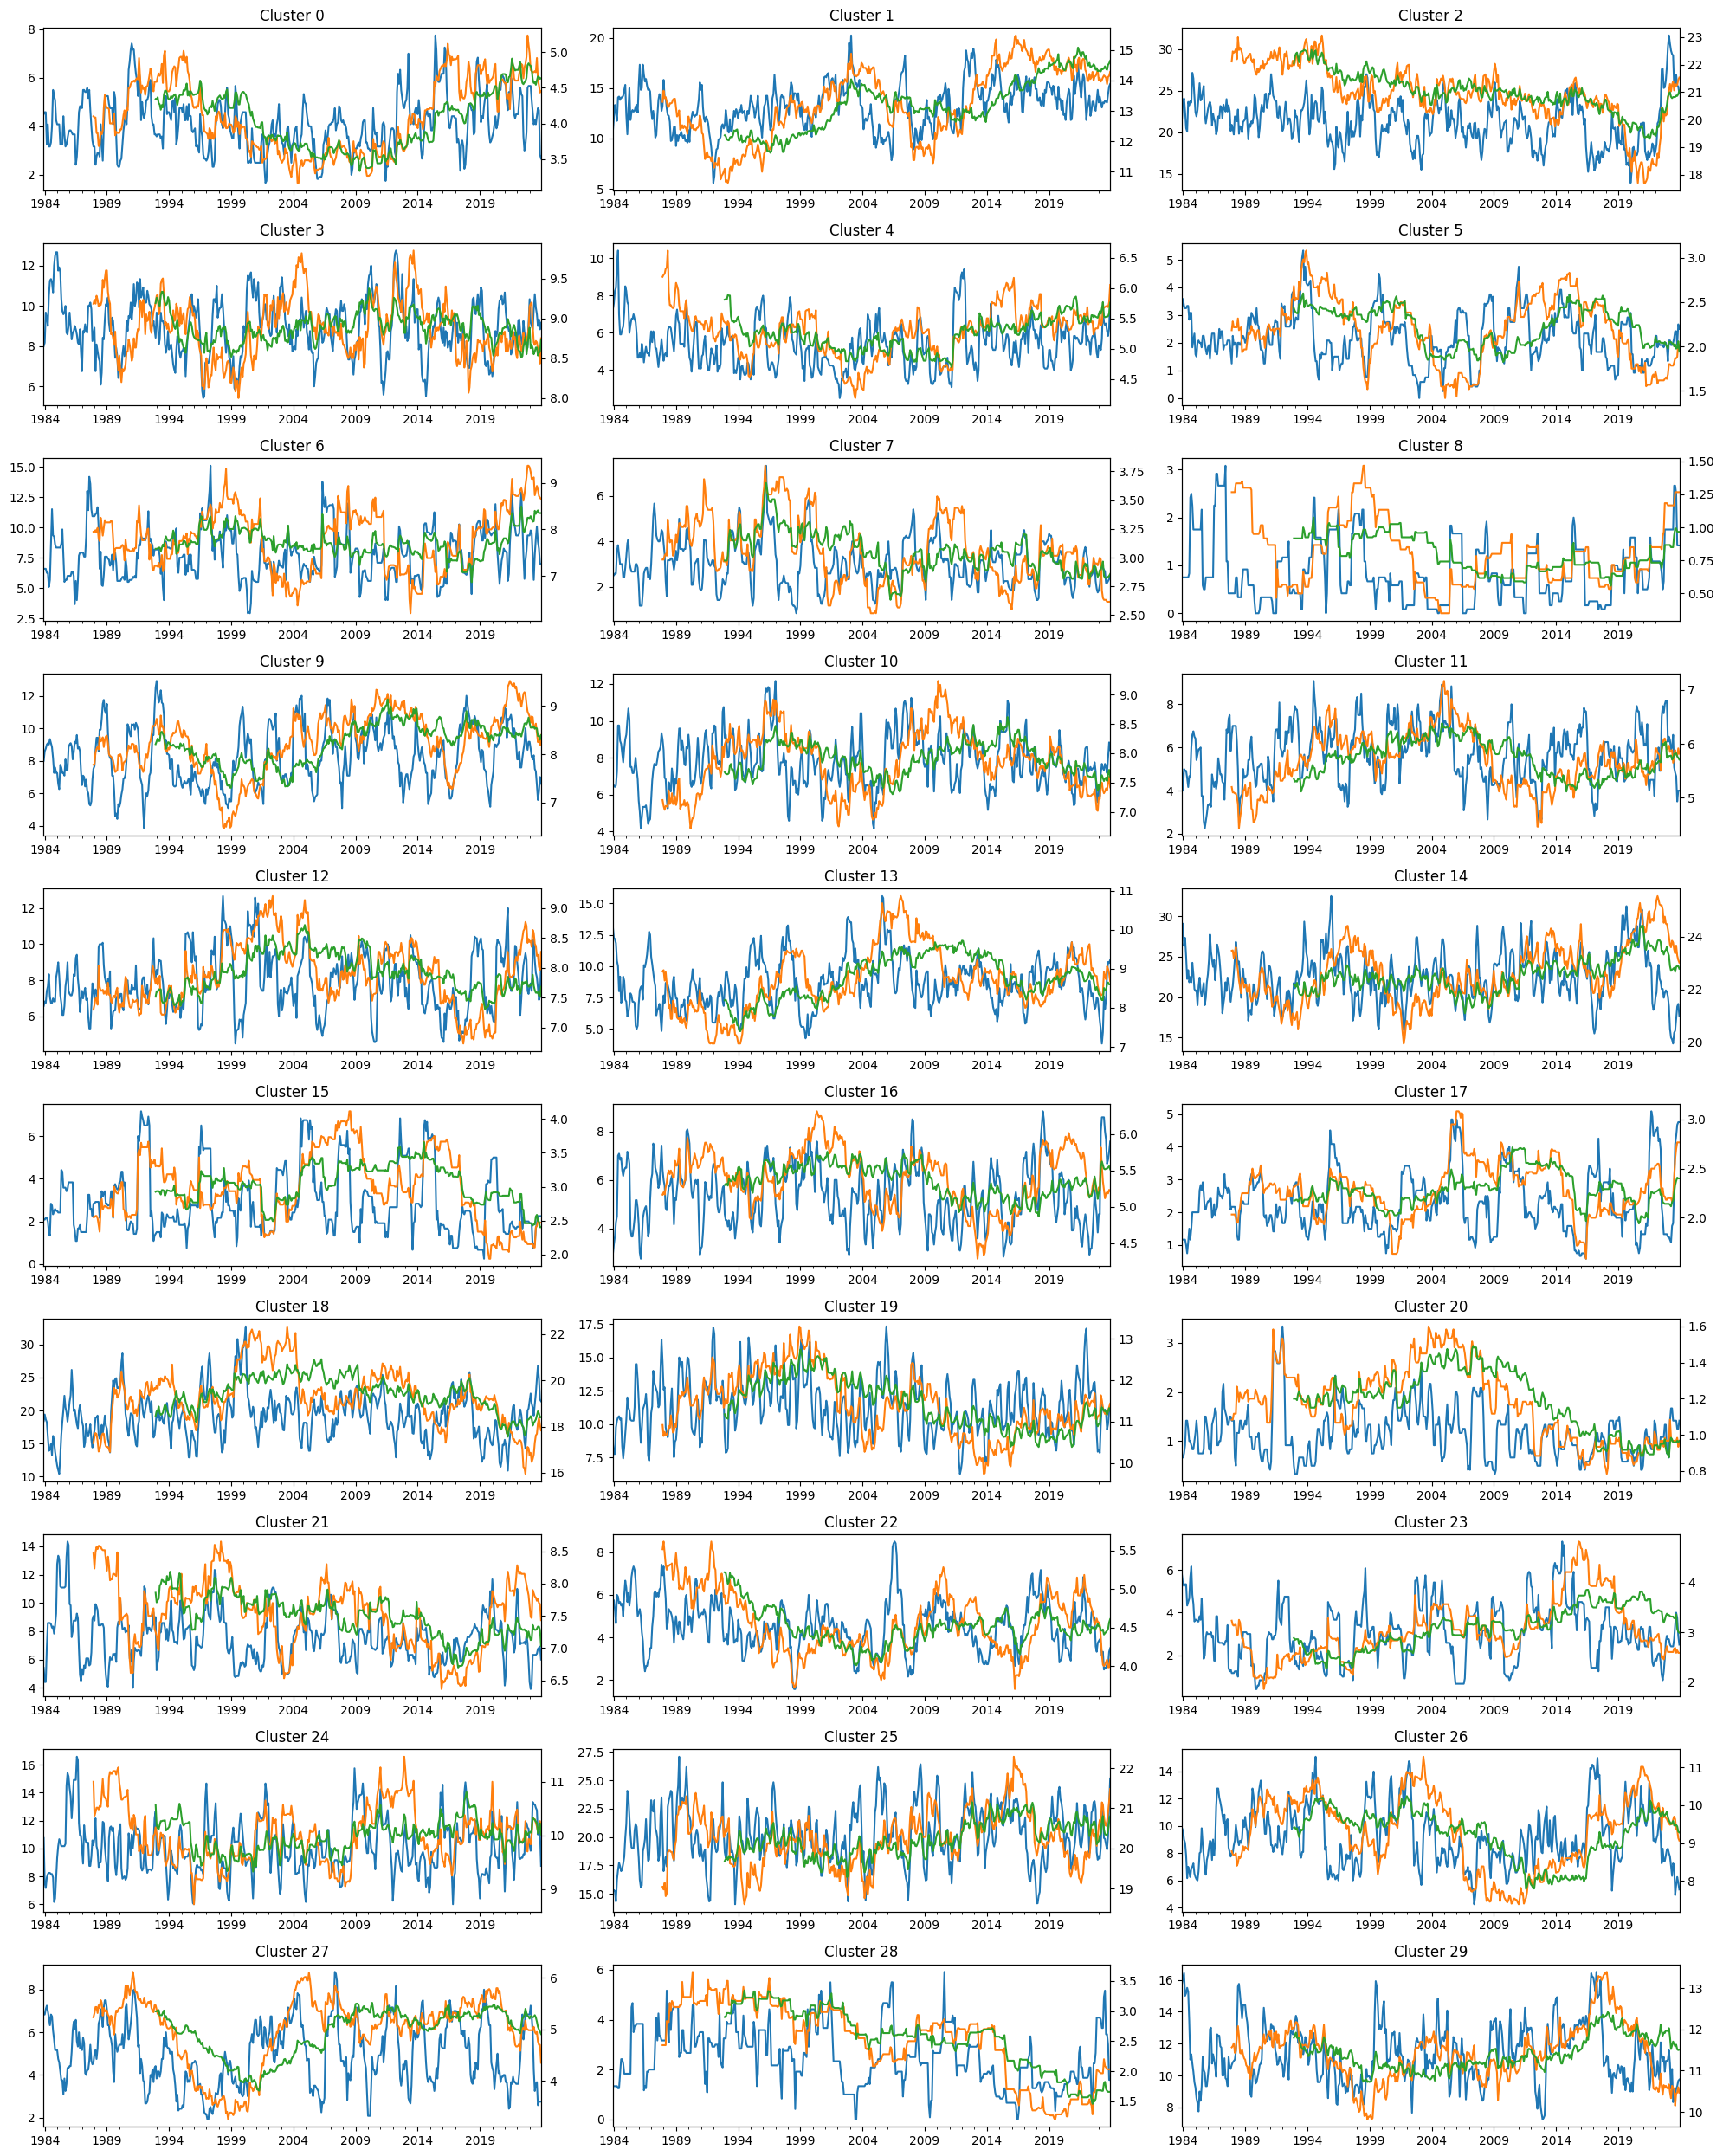

In [10]:
clusters = pd.DataFrame(clusters,index=timseries,columns=['Assigments'])
prop_count = clusters.groupby(pd.Grouper(freq='M'))['Assigments'].value_counts().to_frame().unstack().fillna(0)

blocks = 3
fig, axs = plt.subplots(math.ceil(len(prop_count.columns) / blocks), blocks, figsize=(20, 25))  # Two columns of subplots

for idx, col in enumerate(prop_count.columns):
    row = idx // blocks
    col_idx = idx % blocks
    
    prop_count.rolling(12).mean()[col].dropna().plot(ax=axs[row, col_idx])
    prop_count.rolling(12*5).mean()[col].dropna().plot(ax=axs[row, col_idx],secondary_y=True)
    prop_count.rolling(12*10).mean()[col].dropna().plot(ax=axs[row, col_idx],secondary_y=True)
    
    axs[row, col_idx].set_title(f'Cluster {idx}')
    
plt.tight_layout()
plt.show()